# Delineate Watersheds and write shapefile
Reference : http://mattbartos.com/pysheds/views.html

#### Imports

In [ ]:
# Use environment planet_env(Python 3.11.7)
# !pip install pysheds

In [1]:
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
from shapely.geometry import LineString
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl')
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

#### Directories / files

In [2]:
# Directories
demdir = '/home/etboud/projects/data/cop_DEM/mosaic'
id = 'mosaic_output'
dem_fn = os.path.join(demdir, id+'.tif')

# Instatiate a grid from a raster
grid = Grid.from_raster(dem_fn, data_name='dem')
dem = grid.read_raster(dem_fn, data_name='dem')

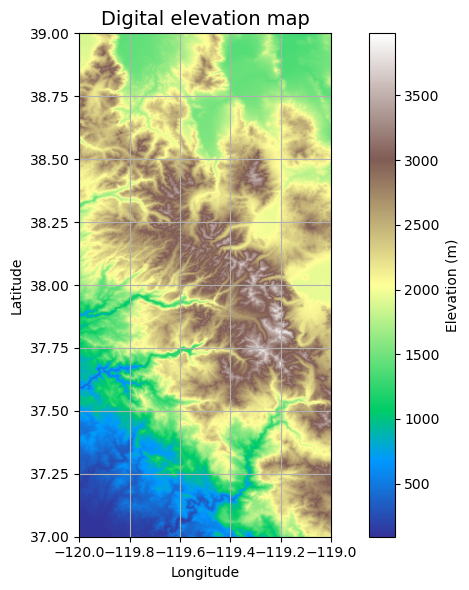

In [3]:
# Elevation map (don't need to run everytime)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Fill in pits on DEM
pixels with values lower than surrounding values may be problematic. Here we give those pixels the same values as their surrounding ones. Now there shouldn't be accumulation issues from the pits.

In [4]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

## Estimating Flow Direction
Here we estimate the direction map, defining 8 possible directions that one cell can follow. Each number is a different direction.

In [5]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

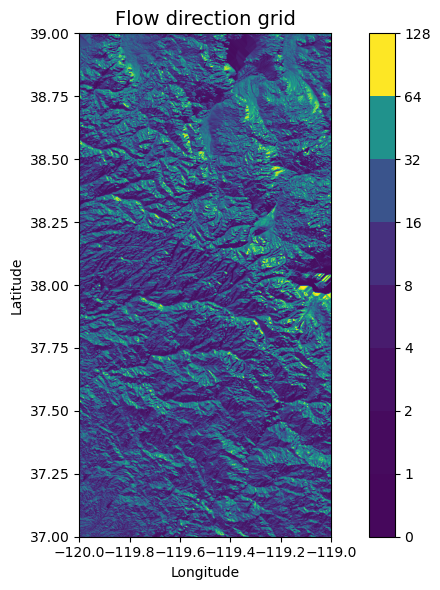

In [6]:
# flow direction plot do not run everytime
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries, values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

## Estimating Flow Accumulation
This part estimates total contributing area for each cell. Sums the number of cells that contribute to each cell.

In [7]:
#Calculate flow accumulation
#--------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [8]:
q01_x,q01_y = -119.26139, 37.77778 #lyell Fork Below Maclure
q02_x,q02_y = -119.3311, 37.869 #Lyell Fk. Tuolumne R. at Twin Bridges
q03_x,q03_y = -119.338, 37.877 #Dana Fk. Tuolumne R. at Bug Camp
q04_x,q04_y = -119.35475, 37.87629 # Tuolumne R. at Highway 120
q05_x,q05_y = -119.381056, 37.883357 # Delaney Cr. At Tuolumne Meadows
q06_x,q06_y = -119.382, 37.873 # Budd Cr. At Tuolumne Meadows brian henn paper
point_x, point_y = -119.7879546, 37.9476989 # outlet
budd_x,budd_y = -119.38418,37.87594

#q06_x,q06_y = -119.873, 37.89489 # Budd Cr. At Tuolumne Meadows readme files dont use

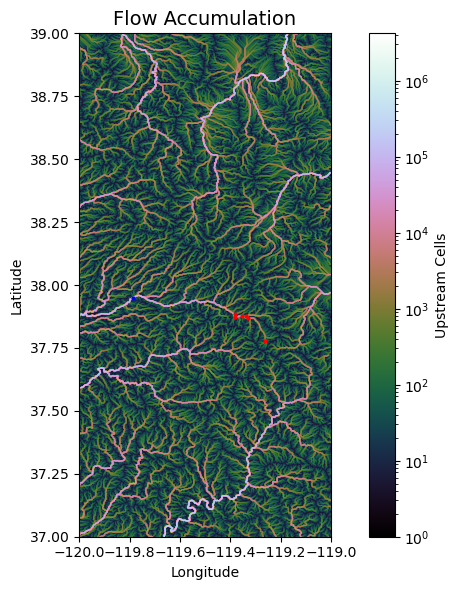

In [10]:
# Flow Accumulation plot (do not need to run everytime)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
point_x, point_y = -119.7879546, 37.9476989
plt.scatter(point_x, point_y, color='blue', s=4, label='Your Point', zorder=2)
plt.scatter(q01_x, q01_y, color='red', s = 4, label='Q01', zorder=2)
plt.scatter(q02_x, q02_y, color='red', s= 4, label='Q02', zorder=2)
plt.scatter(q03_x, q03_y, color='red', s=4, label='Q03', zorder=2)
plt.scatter(q04_x, q04_y, color='red', s=4, label='Q04', zorder=2)
plt.scatter(q05_x, q05_y, color='red', s=4, label='Q05', zorder=2)
plt.scatter(q06_x, q06_y, color='red', s=4, label='Q06', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

## Catchment Delineation
First select the pour point (most downstream of the catchment).You can use QGIS to determine these coordinates by using the Identify Features Icon and clock on the downstream pixel.

Points are snapped to the nearest cell in a binary mask. The 1000 specifies only cells with accumulated flow values greater than 1000 will be considered for snapping

In [11]:
# Delineate a catchment
# ---------------------
# Specify pour point
x,y = budd_x,budd_y

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 20000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)


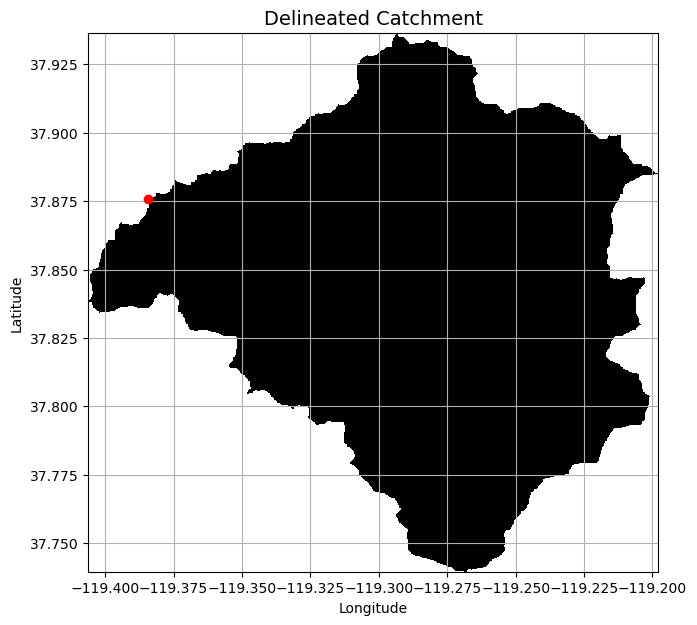

In [12]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
            zorder=1, cmap='Greys_r')
plt.scatter(x, y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

### Create vector representation of catchment mask

In [ ]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

#### Write to shapefile

In [ ]:
shp_fn = 'BUD.shp'

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open(shp_fn, 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

#### Read, inspect, and plot shapefile

In [ ]:
# Read shaefile
shp = gpd.read_file(shp_fn)

# Inspect shapefile
shp

In [ ]:
# Plot shapefile
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

## Extract River Network

If number of flow accumulation is greater than threshold the pixels will be characterized as a river. The lower the number, the denser the river network.

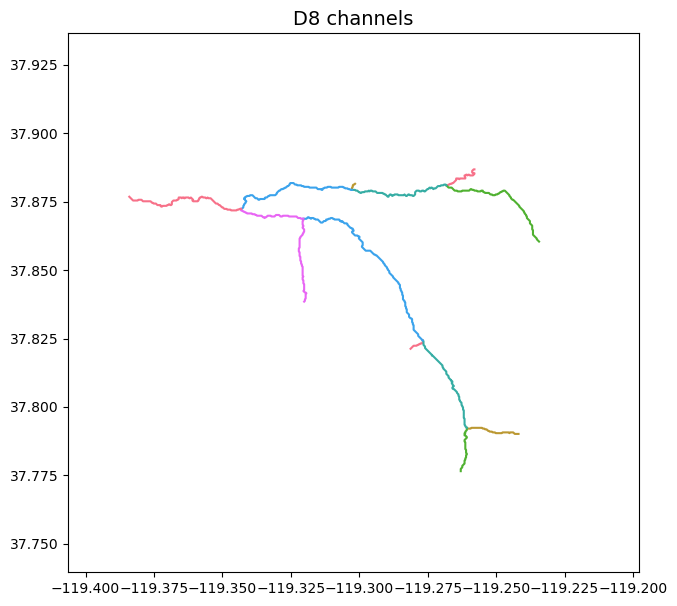

In [13]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 15000, dirmap=dirmap)
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(9,7))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

#### Create shapefile

In [ ]:

network_fn = 'BUDD_network.shp'
schema = {
    'geometry': 'LineString',
    'properties': {}
}

with fiona.open(network_fn, 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for branch in branches['features']:
        rec = {}
        rec['geometry'] = branch['geometry']
        rec['properties'] = {}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

In [ ]:
shp = gpd.read_file(network_fn)
shp.head()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River Network')

#### Flow Distance

In [15]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                               xytype='coordinate')

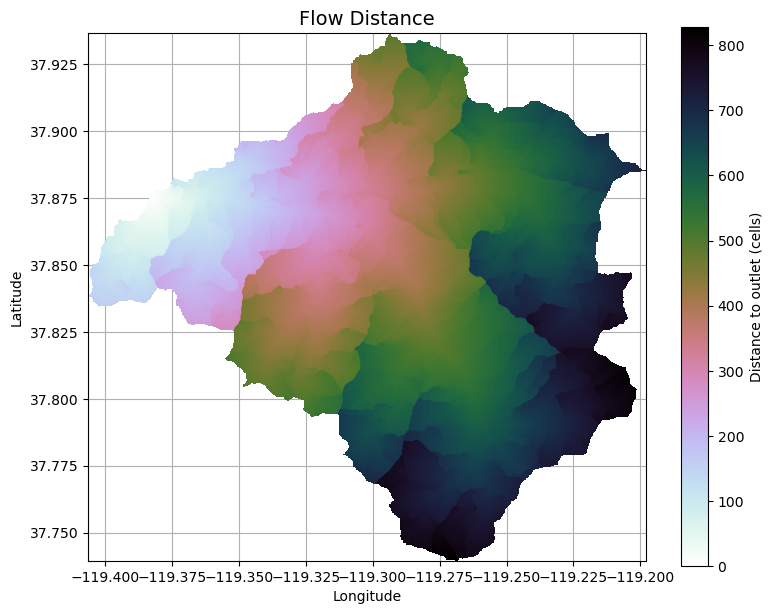

In [17]:
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.xlim(grid.extent[:2])
#ctx.add_basemap(ax=ax,crs=dist.crs,source=ctx.providers.Esri.WorldImagery,attribution='')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

#### To GeoJSON

In [ ]:
import glob
import geopandas as gpd
from shapely.geometry import Polygon

dir = '/home/etboud/projects/data/shp_out/'
fn_list = glob.glob(dir + "*.shp")

for fn in fn_list:
    # Extract file ID
    ID = fn.split("/")[-1].split(".")[0]

    # Read GeoDataFrame from file
    ID_gdf = gpd.read_file(fn)

    # Correct polygons to be in union
    union_geometry = ID_gdf.geometry.unary_union

    # Create GeoSeries from union to convert back to GeoDataFrame
    union_series = gpd.GeoSeries([union_geometry])

    # Create GeoDataFrame for the union
    union_gdf = gpd.GeoDataFrame(geometry=union_series, crs=ID_gdf.crs)
    locals()[f"{ID}_union_gdf"]=union_gdf

In [ ]:
# convert shp file to geojson
budd_union_gdf.to_file('budd_unclip.geojson', driver='GeoJSON')

#### Citation

@misc{bartos_2020,
    title  = {pysheds: simple and fast watershed delineation in python},
    author = {Bartos, Matt},
    url    = {https://github.com/mdbartos/pysheds},
    year   = {2020},
    doi    = {10.5281/zenodo.3822494}
}